In [1]:
.libPaths("/nemo/lab/caladod/working/Matthew/library/R/library/4.3.2_xenium")
library(Seurat)
library(future)
plan("multisession", workers = 10)
library(ggplot2)

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t




In [2]:
#Redefine ReadXenium()
ReadXenium <- function (data.dir, outs = c("matrix", "microns"), type = "centroids", 
          mols.qv.threshold = 20) 
{
  type <- match.arg(arg = type, choices = c("centroids", "segmentations"), 
                    several.ok = TRUE)
  outs <- match.arg(arg = outs, choices = c("matrix", "microns"), 
                    several.ok = TRUE)
  outs <- c(outs, type)
  has_dt <- requireNamespace("data.table", quietly = TRUE) && 
    requireNamespace("R.utils", quietly = TRUE)
  data <- sapply(outs, function(otype) {
    switch(EXPR = otype, matrix = {
      matrix <- suppressWarnings(Read10X(data.dir = file.path(data.dir, 
                                                              "cell_feature_matrix/")))
      matrix
    }, centroids = {
      if (has_dt) {
        cell_info <- as.data.frame(data.table::fread(file.path(data.dir, 
                                                               "cells.csv.gz")))
      } else {
        cell_info <- read.csv(file.path(data.dir, "cells.csv.gz"))
      }
      cell_centroid_df <- data.frame(x = cell_info$x_centroid, 
                                     y = cell_info$y_centroid, cell = cell_info$cell_id, 
                                     stringsAsFactors = FALSE)
      cell_centroid_df
    }, segmentations = {
      if (has_dt) {
        cell_boundaries_df <- as.data.frame(data.table::fread(file.path(data.dir, 
                                                                        "cell_boundaries.csv.gz")))
      } else {
        cell_boundaries_df <- read.csv(file.path(data.dir, 
                                                 "cell_boundaries.csv.gz"), stringsAsFactors = FALSE)
      }
      names(cell_boundaries_df) <- c("cell", "x", "y")
      cell_boundaries_df
    }, microns = {
      
      transcripts <- arrow::read_parquet(file.path(data.dir, "transcripts.parquet"))
      transcripts <- subset(transcripts, qv >= mols.qv.threshold)
      
      df <- data.frame(x = transcripts$x_location, y = transcripts$y_location, 
                       gene = transcripts$feature_name, stringsAsFactors = FALSE)
      df
    }, stop("Unknown Xenium input type: ", otype))
  }, USE.NAMES = TRUE)

  segmentations.data <- list(centroids = CreateCentroids(data$centroids), 
                           segmentation = CreateSegmentation(data$microns))
  coords <- CreateFOV(coords = segmentations.data, type = c("segmentation", 
                                                            "centroids"), molecules = data$microns, assay = "RNA")
  xenium.obj <- CreateSeuratObject(counts = data$matrix[["Gene Expression"]], 
                                  assay = "RNA")
  xenium.obj[["BlankCodeword"]] <- CreateAssayObject(counts = data$matrix[["Unassigned Codeword"]])
  xenium.obj[["ControlCodeword"]] <- CreateAssayObject(counts = data$matrix[["Negative Control Codeword"]])
  xenium.obj[["ControlProbe"]] <- CreateAssayObject(counts = data$matrix[["Negative Control Probe"]])
  xenium.obj[["fov"]] <- coords
  
  return(xenium.obj)
}

In [ ]:
suppressMessages({
    path <- "/camp/home/hungm/scratch/hungm/matthew/MH_Hackathon/2025_CRUK/data/Xenium/Prime5k/"
    # need "cell_feature_matrix", "transcripts.csv.gz", "cell.csv.gz"
    xenium.obj <- ReadXenium(path)}
)

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



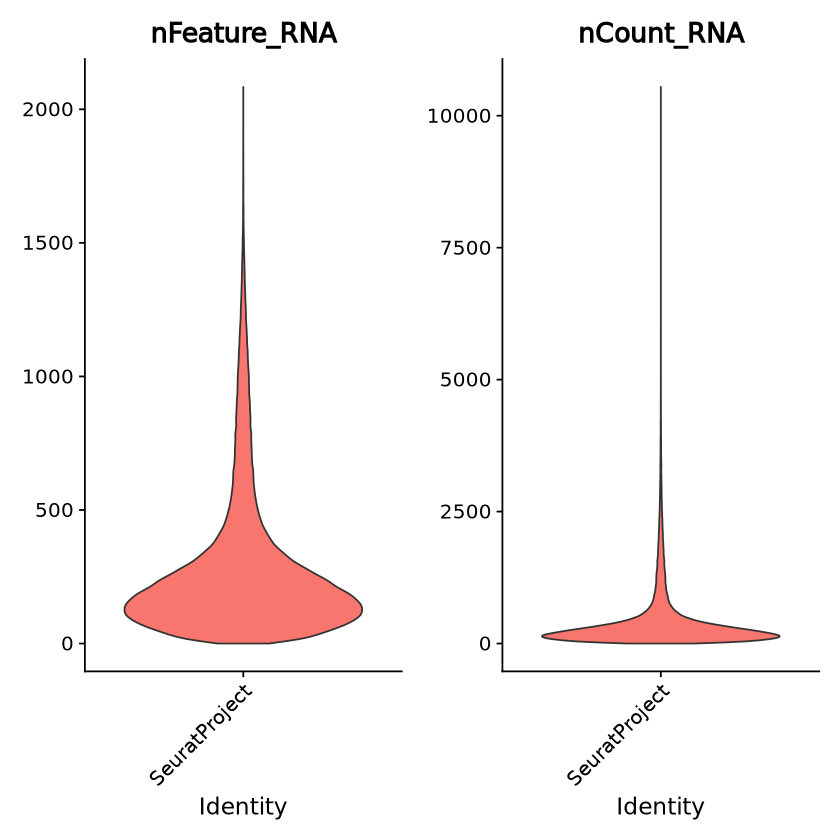

In [22]:
VlnPlot(xenium.obj, features = c("nFeature_RNA", "nCount_RNA"), ncol = 2, pt.size = 0)

In [4]:
colnames(xenium.obj@meta.data)

[1] "orig.ident"               "nCount_RNA"              
[3] "nFeature_RNA"             "nCount_BlankCodeword"    
[5] "nFeature_BlankCodeword"   "nCount_ControlCodeword"  
[7] "nFeature_ControlCodeword" "nCount_ControlProbe"     
[9] "nFeature_ControlProbe"

In [5]:
luad.genes <- read.csv("/camp/home/hungm/scratch/hungm/matthew/MH_Hackathon/2025_CRUK/data/TCGA2/2_metastatic_genes/TCGA_LUAD_univariate_lasso.txt", header = F)[[1]]
head(luad.genes)

[1] "ACOT12"  "ACOXL"   "ADAM5P"  "ARPM1"   "ATG10"   "B3GALTL"

In [6]:
length(luad.genes)

[1] 110

In [7]:
length(which(rownames(xenium.obj) %in% luad.genes))

[1] 20

In [8]:
luad.genes.xenium <- rownames(xenium.obj)[rownames(xenium.obj) %in% luad.genes]

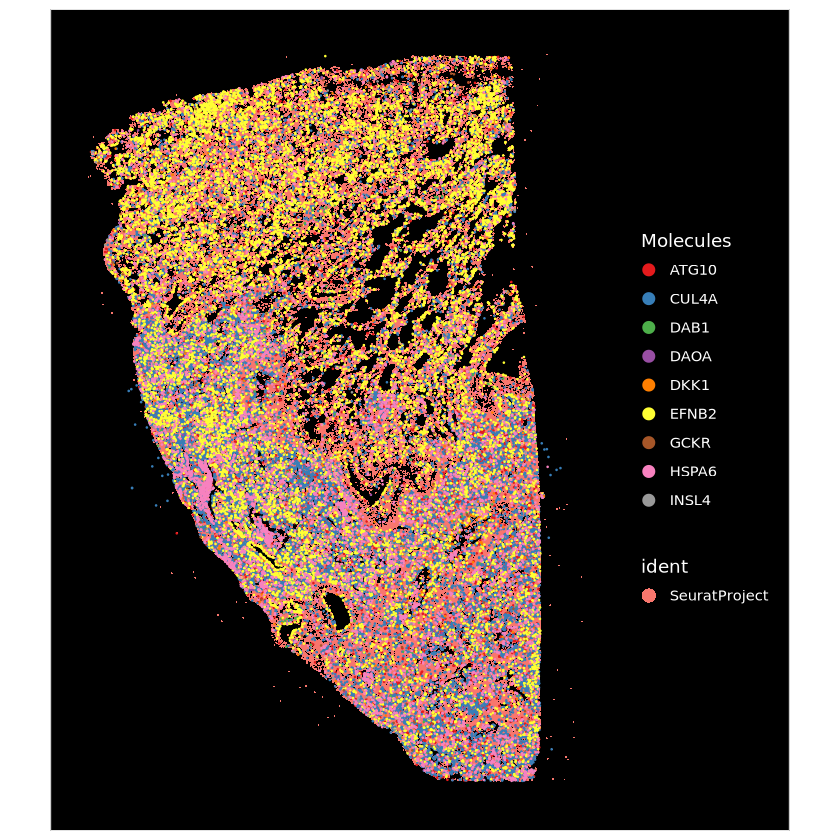

In [9]:
ImageDimPlot(xenium.obj, fov = "fov", molecules = luad.genes.xenium[1:9], nmols = 20000)

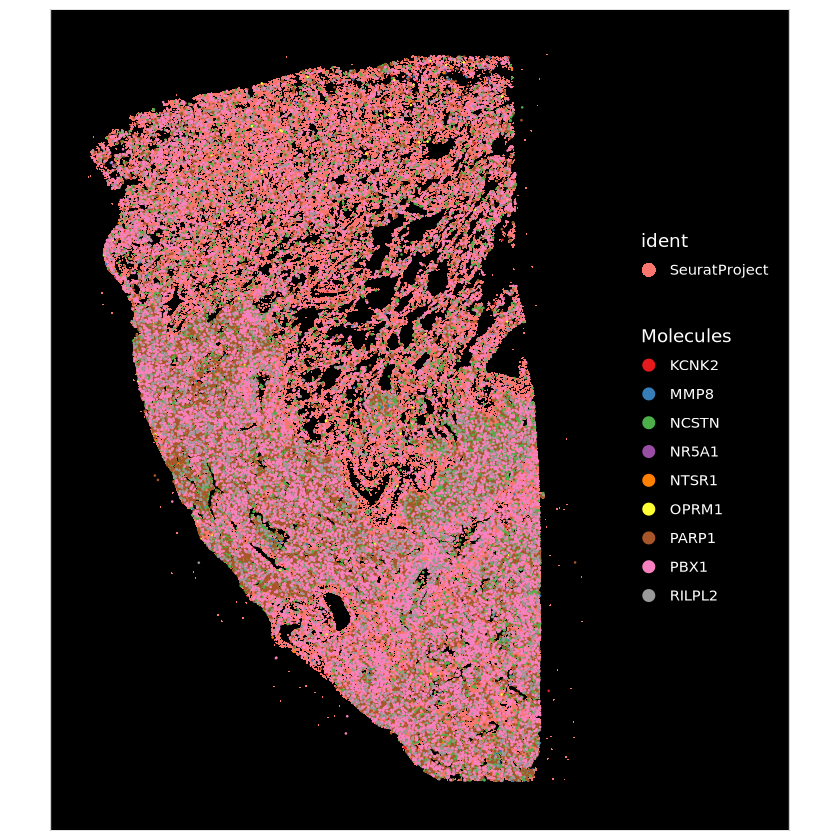

In [10]:
ImageDimPlot(xenium.obj, fov = "fov", molecules = luad.genes.xenium[10:18], nmols = 20000)

Warning message in brewer.pal(n = length(x = levels(x = molecules$molecule)), name = "Set1"):
“minimal value for n is 3, returning requested palette with 3 different levels
”


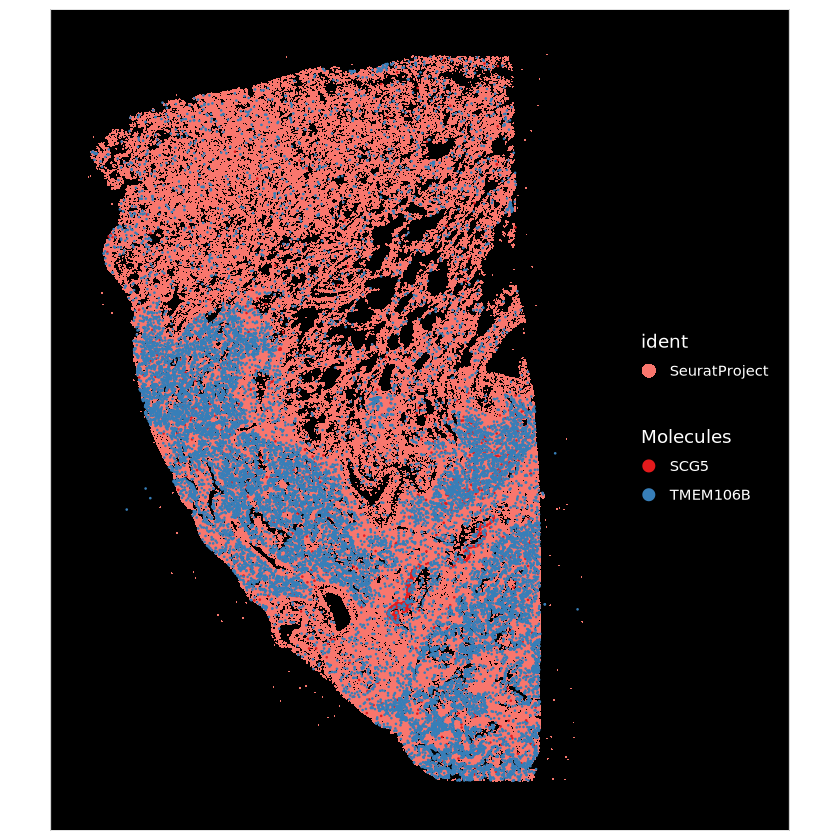

In [11]:
ImageDimPlot(xenium.obj, fov = "fov", molecules = luad.genes.xenium[19:20], nmols = 20000)

In [12]:
plan("multisession", workers = 1)
xenium.obj <- NormalizeData(xenium.obj)

Normalizing layer: counts



In [13]:
library(UCell)
xenium.obj <- AddModuleScore_UCell(xenium.obj, features = list(LUADGS = luad.genes.xenium), assay = "RNA")

In [14]:
colnames(xenium.obj@meta.data)

[1] "orig.ident"               "nCount_RNA"              
 [3] "nFeature_RNA"             "nCount_BlankCodeword"    
 [5] "nFeature_BlankCodeword"   "nCount_ControlCodeword"  
 [7] "nFeature_ControlCodeword" "nCount_ControlProbe"     
 [9] "nFeature_ControlProbe"    "LUADGS_UCell"

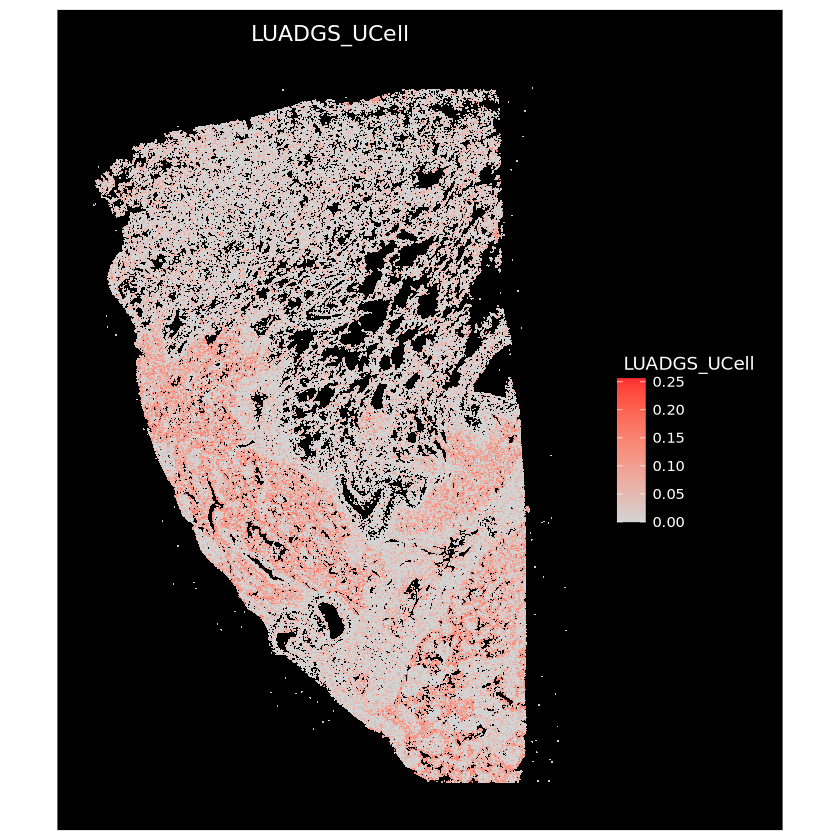

In [16]:
ImageFeaturePlot(xenium.obj, fov = "fov",  features = "LUADGS_UCell", nmols = 20000)

In [65]:
summary(as.numeric(xenium.obj@meta.data$LUADGS_UCell))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.00000 0.00000 0.02460 0.05541 0.35481 

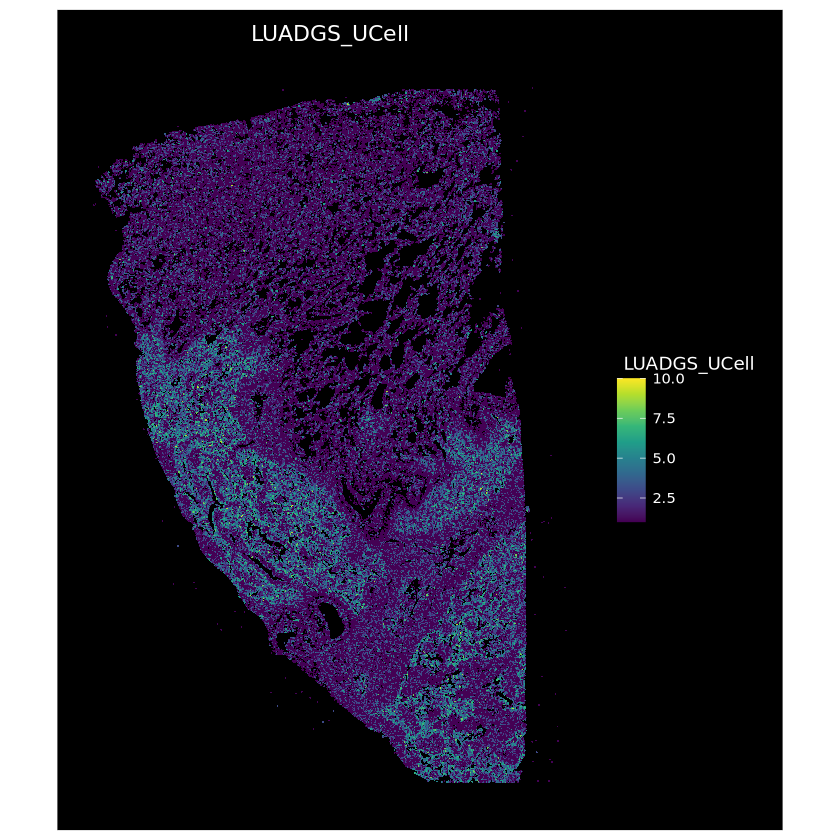

In [15]:
colors <- viridis::viridis(10)
ImageFeaturePlot(xenium.obj, fov = "fov",  features = "LUADGS_UCell", nmols = 20000, cols = colors)

In [45]:
tiff("/camp/home/hungm/scratch/hungm/matthew/MH_Hackathon/2025_CRUK/data/TCGA2/4_xenium/xenium_featureplot.tiff", width = 5000, height = 5000,res = 300)
colors <- viridis::viridis(10)
print(
    ImageFeaturePlot(xenium.obj, fov = "fov", features = "LUADGS_UCell", nmols = 20000, cols = colors))
dev.off()

png 
  2

In [19]:
## 20 genes
write.table(luad.genes.xenium, "/camp/home/hungm/scratch/hungm/matthew/MH_Hackathon/2025_CRUK/data/TCGA2/4_xenium/xenium20.txt", col.names = F, row.names = F, quote = F)

In [18]:
length(luad.genes.xenium)

[1] 20